In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
df = pd.read_csv('synthetic_loan_data.csv')
df

,CustomerID,Name,Age,Gender,MaritalStatus,EducationLevel,EmploymentStatus,AnnualIncome,LoanAmountRequested,PurposeOfLoan,CreditScore,ExistingLoansCount,LatePaymentsLastYear,LoanApproved
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,Michelle Prince,56,Male,Divorced,Other,Employed,97622,46413,Personal,500,2,4,Yes
1,23b8c1e9-3924-46de-beb1-3b9046685257,Diana Mullins,69,Male,Married,Bachelor,Employed,96925,24065,Home,532,2,0,Yes
2,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,Brittany Ballard,46,Female,Single,High School,Self-employed,167927,46676,Personal,795,2,6,Yes
3,972a8469-1641-4f82-8b9d-2434e465e150,Matthew Freeman,32,Female,Widowed,PhD,Unemployed,112920,27406,Education,376,2,9,No
4,17fc695a-07a0-4a6e-8822-e8f36c031199,Amy Baker,60,Female,Widowed,Master,Unemployed,152183,49337,Car,517,3,7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,bdcfc42b-8122-41db-aa6a-58b294568b74,Jose Torres,22,Female,Divorced,Other,Student,178359,48541,Education,363,2,8,Yes
8996,a874d557-cd0e-4708-acbf-81d4b1720b65,Michael Butler,26,Female,Widowed,Other,Self-employed,126938,33411,Education,379,4,7,Yes
8997,8a4f48b2-d251-43ad-880b-dbd7657050ee,Veronica Avila,19,Male,Married,PhD,Student,119957,47023,Car,693,2,6,Yes
8998,8d5af123-085d-47e6-872c-5869d4c933f2,Kayla Miller,51,Female,Married,PhD,Retired,160226,31385,Personal,649,4,7,No


In [4]:
# data overview
print(df.shape)
print(df.info())
print(df.describe())

(9000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerID            9000 non-null   object
 1   Name                  9000 non-null   object
 2   Age                   9000 non-null   int64 
 3   Gender                9000 non-null   object
 4   MaritalStatus         9000 non-null   object
 5   EducationLevel        9000 non-null   object
 6   EmploymentStatus      9000 non-null   object
 7   AnnualIncome          9000 non-null   int64 
 8   LoanAmountRequested   9000 non-null   int64 
 9   PurposeOfLoan         9000 non-null   object
 10  CreditScore           9000 non-null   int64 
 11  ExistingLoansCount    9000 non-null   int64 
 12  LatePaymentsLastYear  9000 non-null   int64 
 13  LoanApproved          9000 non-null   object
dtypes: int64(6), object(8)
memory usage: 984.5+ KB
None
               Age   Annu

In [5]:
#drop unecessary columns
df = df.drop(["CustomerID", "Name"], axis=1)

Dropping unecessary columns cleans the data as they add no value to prediction, the redundant columns will cause noise to the model which can cause overfitting and data leakage.

In [6]:
# Check for missing values
print(df.isnull().sum())

Age                     0
Gender                  0
MaritalStatus           0
EducationLevel          0
EmploymentStatus        0
AnnualIncome            0
LoanAmountRequested     0
PurposeOfLoan           0
CreditScore             0
ExistingLoansCount      0
LatePaymentsLastYear    0
LoanApproved            0
dtype: int64


Checks for columns with missing data for cleaning

In [7]:
# List unique values for each categorical column
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Gender: ['Male' 'Female']
MaritalStatus: ['Divorced' 'Married' 'Single' 'Widowed']
EducationLevel: ['Other' 'Bachelor' 'High School' 'PhD' 'Master']
EmploymentStatus: ['Employed' 'Self-employed' 'Unemployed' 'Retired' 'Student']
PurposeOfLoan: ['Personal' 'Home' 'Education' 'Car' 'Business']
LoanApproved: ['Yes' 'No']


Checks for categories that may need to be encoded later on

In [27]:
# Convert income and loan columns to numeric if needed
df['AnnualIncome'] = pd.to_numeric(df['AnnualIncome'], errors='coerce')
df['LoanAmountRequested'] = pd.to_numeric(df['LoanAmountRequested'], errors='coerce')

# Create Loan to Income Ratio
df['Loan_to_Income'] = df['LoanAmountRequested'] / (df['AnnualIncome'] + 1)

# Optional: fill missing if any
df['Loan_to_Income'].fillna(df['Loan_to_Income'].median(), inplace=True)

# Check result
df[['LoanAmountRequested', 'AnnualIncome', 'Loan_to_Income']].head()

C:\Users\chaya\AppData\Local\Temp\ipykernel_12552\1083209142.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Loan_to_Income'].fillna(df['Loan_to_Income'].median(), inplace=True)


,LoanAmountRequested,AnnualIncome,Loan_to_Income
0,46413,97622,0.475431
1,24065,96925,0.248282
2,46676,167927,0.277952
3,27406,112920,0.242701
4,49337,152183,0.324193


LoanApproved
Yes    6303
No     2697
Name: count, dtype: int64


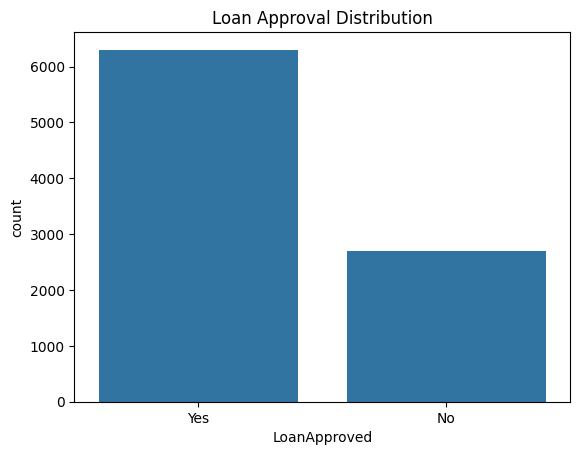

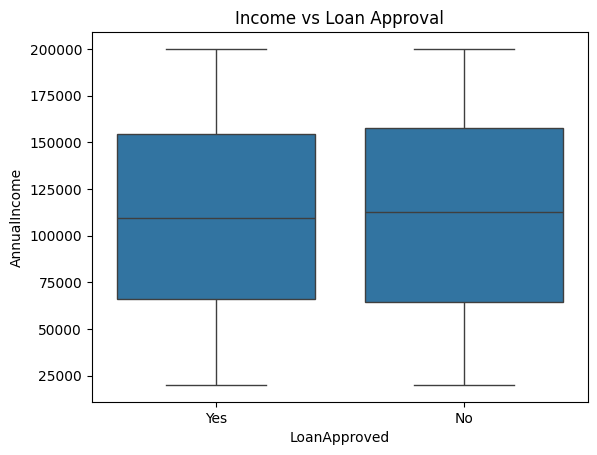

In [9]:
# Check class distribution for target
print(df['LoanApproved'].value_counts())

# Visualize target distribution
sns.countplot(x='LoanApproved', data=df)
plt.title('Loan Approval Distribution')
plt.show()

# checks for class imbalance
sns.boxplot(x='LoanApproved', y='AnnualIncome', data=df)
plt.title('Income vs Loan Approval')
plt.show()

Checks for class balance and have a visual check.
The box plot is to see how numeric features differ between approved and not approved loans.

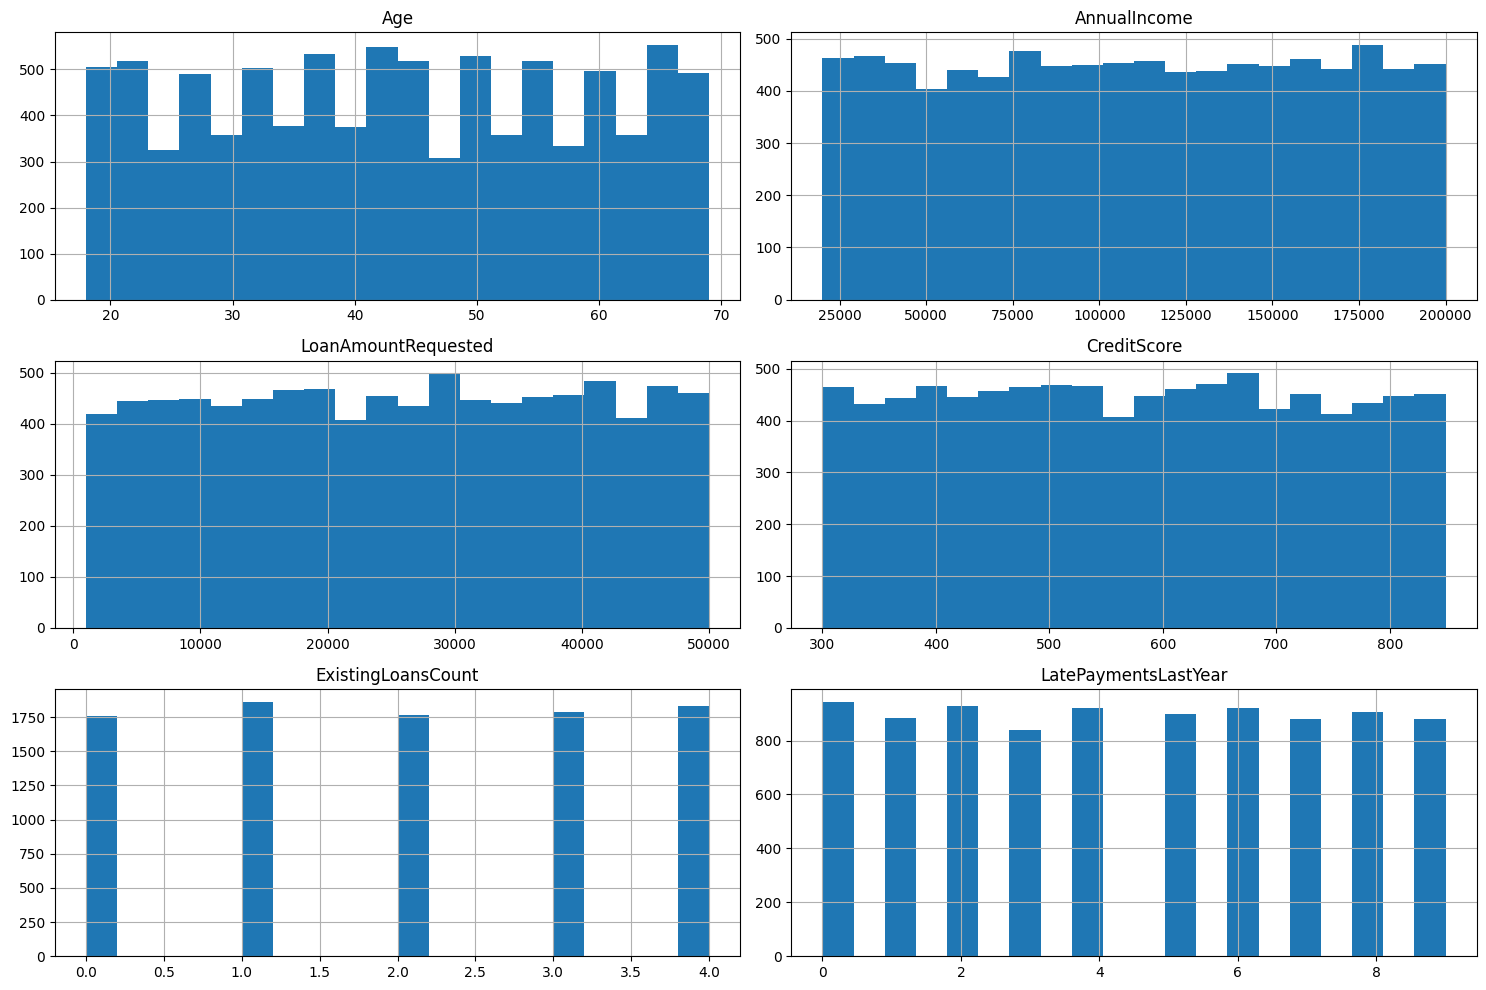

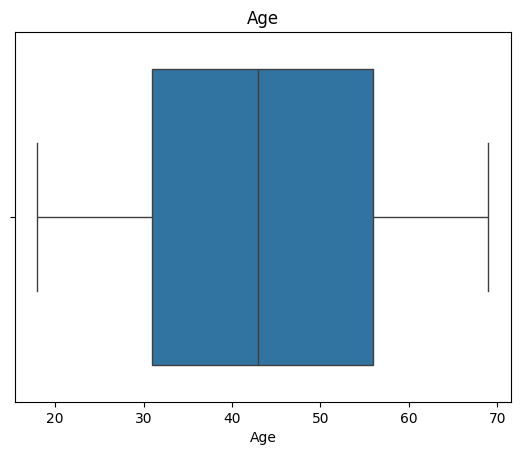

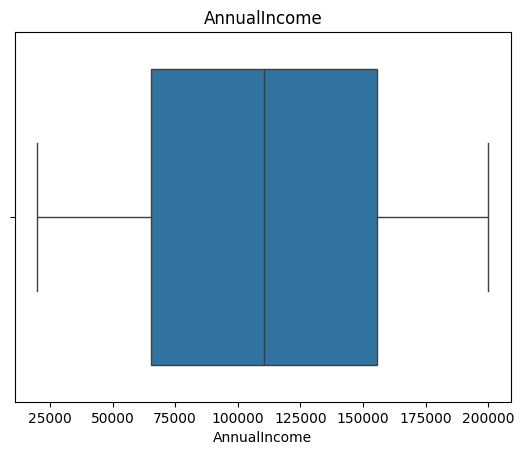

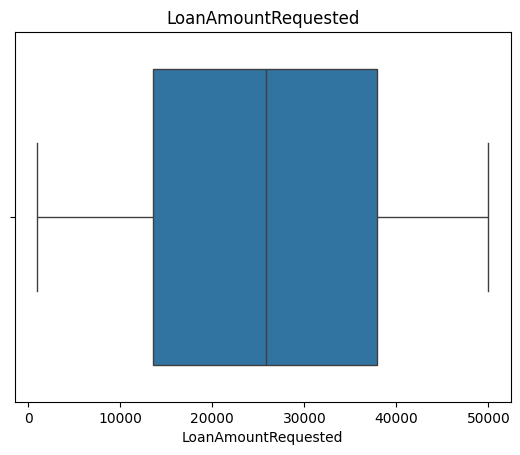

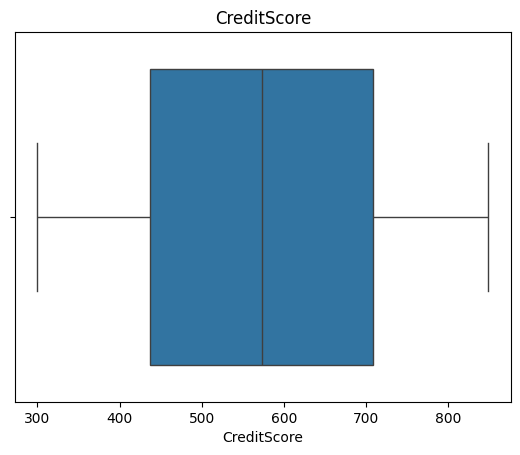

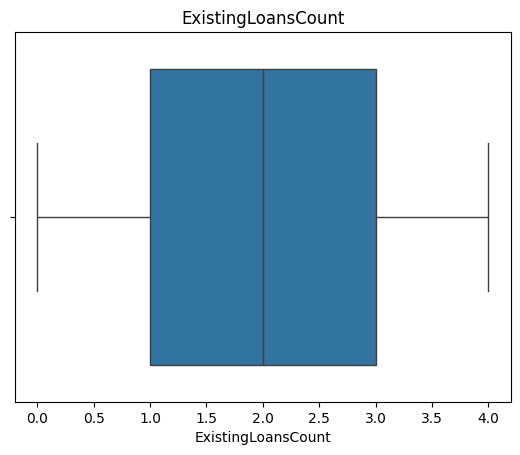

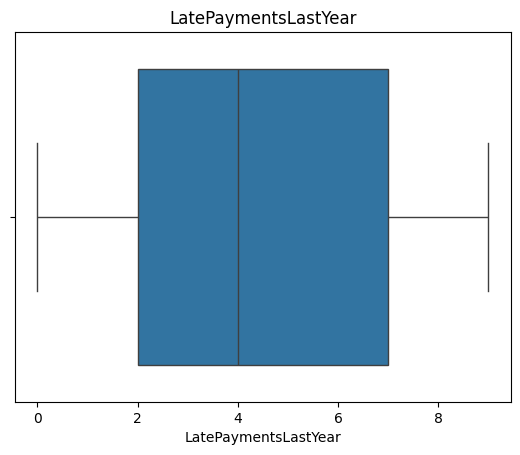

In [10]:
# Histogram for numeric columns
df.hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

# Boxplots for outlier detection
for col in df.select_dtypes(include='number').columns:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

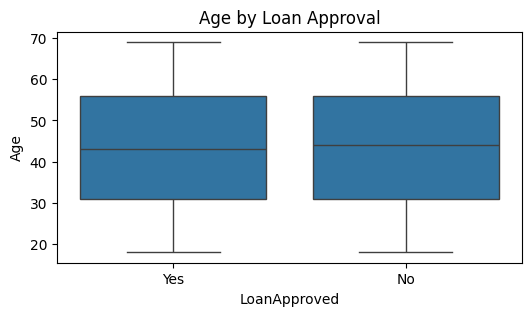

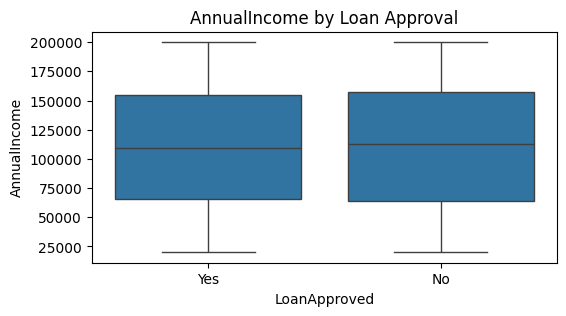

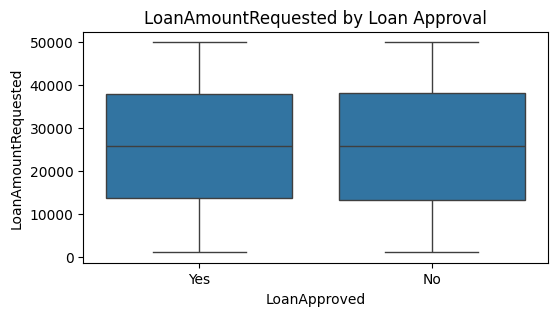

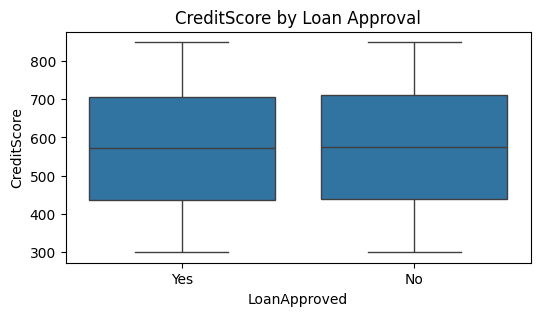

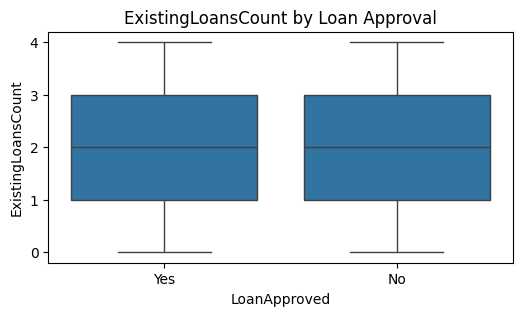

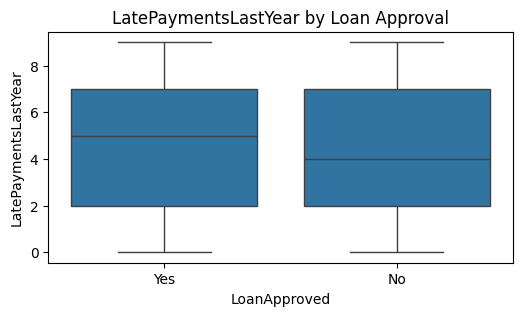

In [11]:
# Boxplots for numerical features grouped by target
# see which features differ most between approved and not approved loans
num_cols = df.select_dtypes(include='number').columns
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='LoanApproved', y=col, data=df)
    plt.title(f'{col} by Loan Approval')
    plt.show()

Visualise and identify distributions to spot outliers

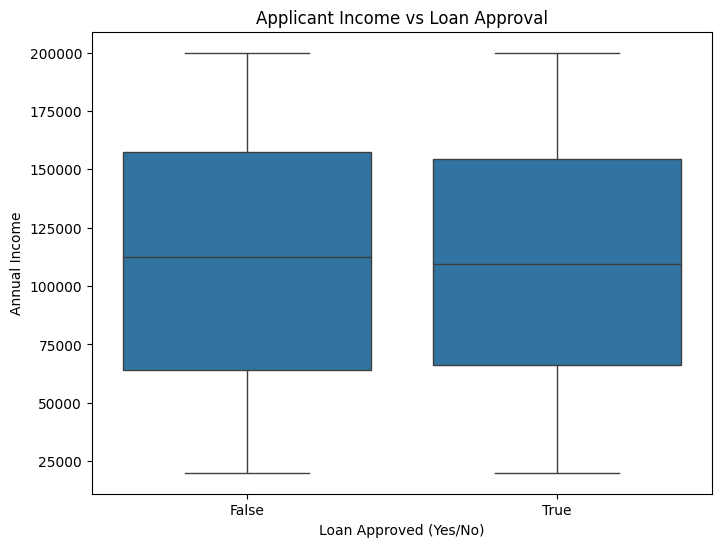

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='LoanApproved_Yes', y='AnnualIncome', data=df_encoded)
plt.title('Applicant Income vs Loan Approval')
plt.xlabel('Loan Approved (Yes/No)')
plt.ylabel('Annual Income')
plt.show()


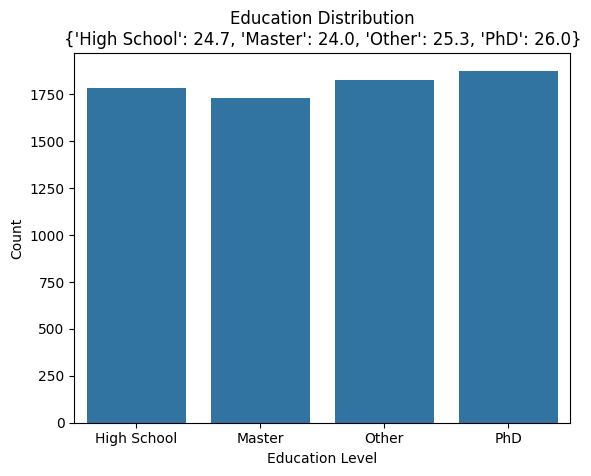

In [26]:
# Plot education distribution from one-hot encoded columns
edu_cols = [
	'EducationLevel_High School',
	'EducationLevel_Master',
	'EducationLevel_Other',
	'EducationLevel_PhD'
]
edu_labels = ['High School', 'Master', 'Other', 'PhD']
edu_counts = df_encoded[edu_cols].sum().values
edu_percent = edu_counts / edu_counts.sum() * 100

sns.barplot(x=edu_labels, y=edu_counts)
plt.title(f'Education Distribution\n{dict(zip(edu_labels, edu_percent.round(1)))}')
plt.ylabel('Count')
plt.xlabel('Education Level')
plt.show()


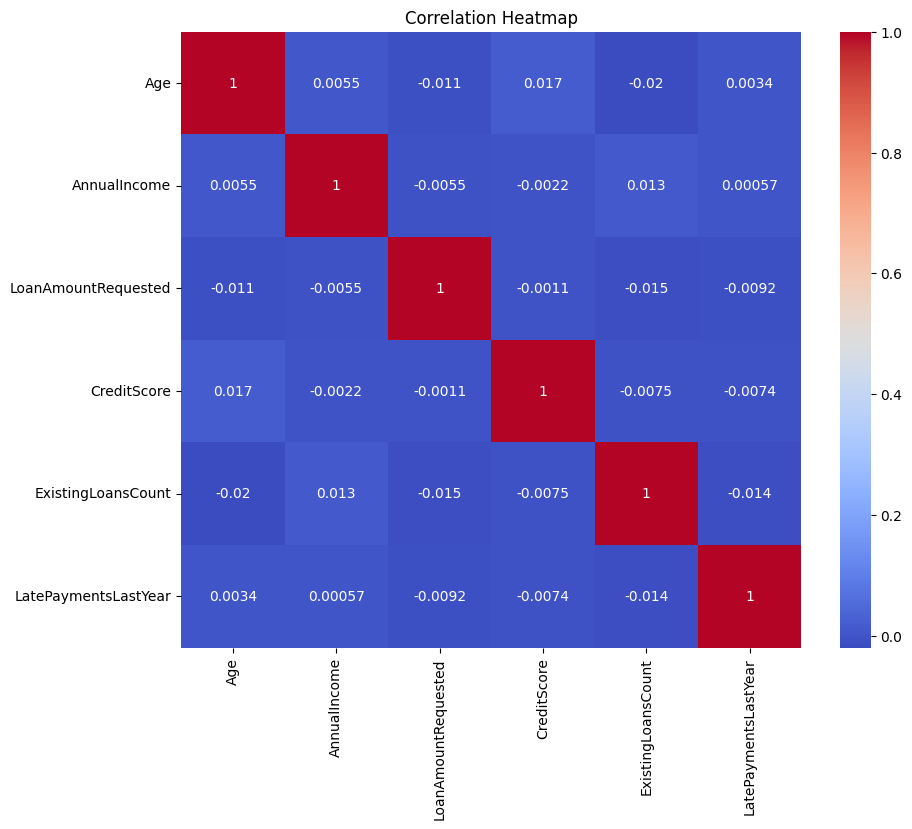

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


 Higher income applicants tend to get approved more (visible in the boxplot).
- Education level appears balanced, with most being graduates.
- The correlation heatmap shows that Credit_History and LoanAmount are important features.
- A new feature `Loan_to_Income` has been added to capture affordability.

In [15]:
# Compare means by target
print(df.groupby('LoanApproved').mean(numeric_only=True))

# Categorical features vs target
for col in categorical_cols:
    if col != 'LoanApproved':
        print(df.groupby(col)['LoanApproved'].value_counts(normalize=True))

                    Age   AnnualIncome  LoanAmountRequested  CreditScore  \
LoanApproved                                                               
No            43.701149  111281.496478         25634.187616   573.768632   
Yes           43.485959  109851.194828         25700.435666   572.947168   

              ExistingLoansCount  LatePaymentsLastYear  
LoanApproved                                            
No                      1.989989              4.412310  
Yes                     2.016341              4.502459  
Gender  LoanApproved
Female  Yes             0.707219
        No              0.292781
Male    Yes             0.693484
        No              0.306516
Name: proportion, dtype: float64
MaritalStatus  LoanApproved
Divorced       Yes             0.691189
               No              0.308811
Married        Yes             0.696507
               No              0.303493
Single         Yes             0.709181
               No              0.290819
Widowed      

See proportion of loan approvals within each category

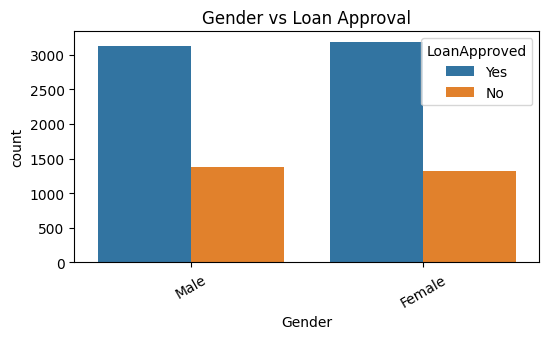

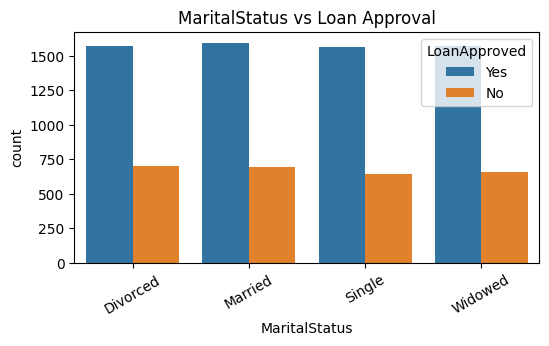

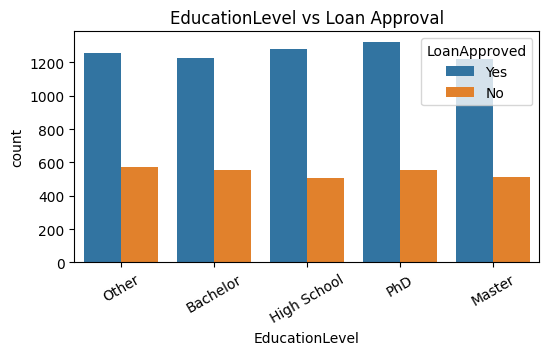

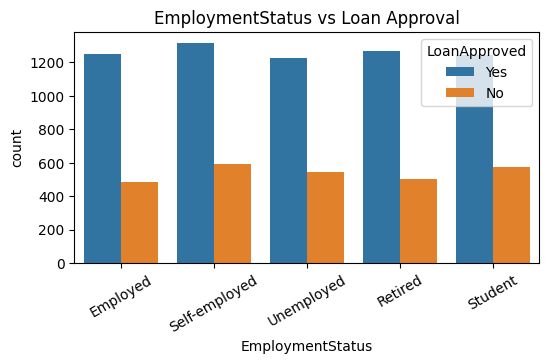

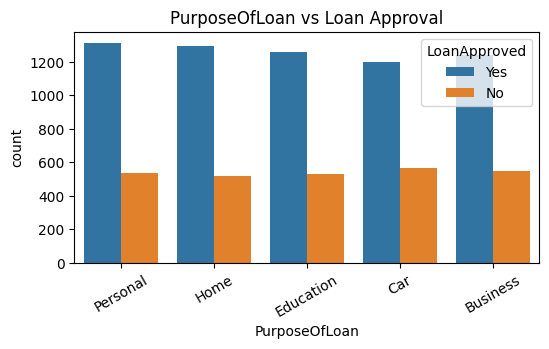

In [16]:
# Bar plots for categorical features vs target
cat_cols = [col for col in categorical_cols if col != 'LoanApproved']
for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, hue='LoanApproved', data=df)
    plt.title(f'{col} vs Loan Approval')
    plt.xticks(rotation=30)
    plt.show()

Visualise relationship between categorical features and loan approval

Checks how numeric features differ by laon approval status

Model building and evaluation

In [17]:
# Encode categorical variables
# Use one-hot encoding for categorical features
df_encoded = pd.get_dummies(df, drop_first=True)
# Create Debt-to-Income Ratio
# debt-to-incone is a common feature in loan datasets
df_encoded['DebtToIncome'] = df_encoded['LoanAmountRequested'] / (df_encoded['AnnualIncome'] + 1)

convert categorical features to be used for modeling

In [18]:
# Remove outliers in CreditScore (example: outside 1.5*IQR)
# outliers can skew model training
Q1 = df_encoded['CreditScore'].quantile(0.25)
Q3 = df_encoded['CreditScore'].quantile(0.75)
IQR = Q3 - Q1
mask = (df_encoded['CreditScore'] >= Q1 - 1.5*IQR) & (df_encoded['CreditScore'] <= Q3 + 1.5*IQR)
df_clean = df_encoded[mask]

remove outliers to improve model accuracy

In [19]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('LoanApproved_Yes', axis=1)
y = df_encoded['LoanApproved_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

c:\Users\chaya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chaya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chaya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Logistic Regression:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00       549
        True       0.69      1.00      0.82      1251

    accuracy                           0.69      1800
   macro avg       0.35      0.50      0.41      1800
weighted avg       0.48      0.69      0.57      1800

Random Forest:
               precision    recall  f1-score   support

       False       0.35      0.01      0.03       549
        True       0.70      0.99      0.82      1251

    accuracy                           0.69      1800
   macro avg       0.52      0.50      0.42      1800
weighted avg       0.59      0.69      0.58      1800



              precision    recall  f1-score   support

       False       0.00      0.00      0.00       549
        True       0.69      1.00      0.82      1251

    accuracy                           0.69      1800
   macro avg       0.35      0.50      0.41      1800
weighted avg       0.48      0.69      0.57      1800



c:\Users\chaya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chaya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chaya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

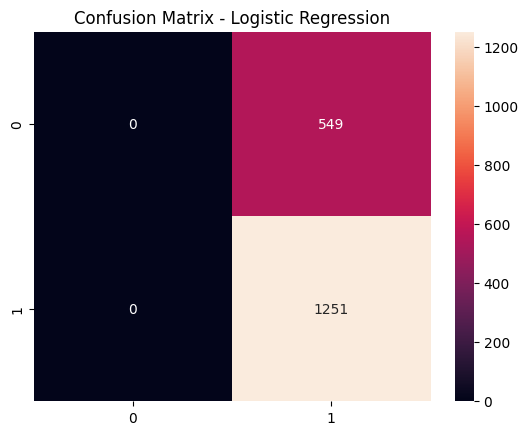

In [21]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


visualise true/false positives/negatives and compares predicted value and actual value

In [22]:
# Hyperparameter tuning for Random Forest
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# Evaluate best estimator
best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Tuned Random Forest:\n", classification_report(y_test, y_pred_best_rf))


Best Params: {'max_depth': 10, 'n_estimators': 50}
Best CV Score: 0.7020833333333334
Tuned Random Forest:
               precision    recall  f1-score   support

       False       0.33      0.00      0.00       549
        True       0.70      1.00      0.82      1251

    accuracy                           0.69      1800
   macro avg       0.51      0.50      0.41      1800
weighted avg       0.58      0.69      0.57      1800



Fidn best parameters to improve modeal perforance

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

y_pred = best_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

       False       0.33      0.00      0.00       549
        True       0.70      1.00      0.82      1251

    accuracy                           0.69      1800
   macro avg       0.51      0.50      0.41      1800
weighted avg       0.58      0.69      0.57      1800

Confusion Matrix:
 [[   1  548]
 [   2 1249]]
F1 Score: 0.8195538057742782


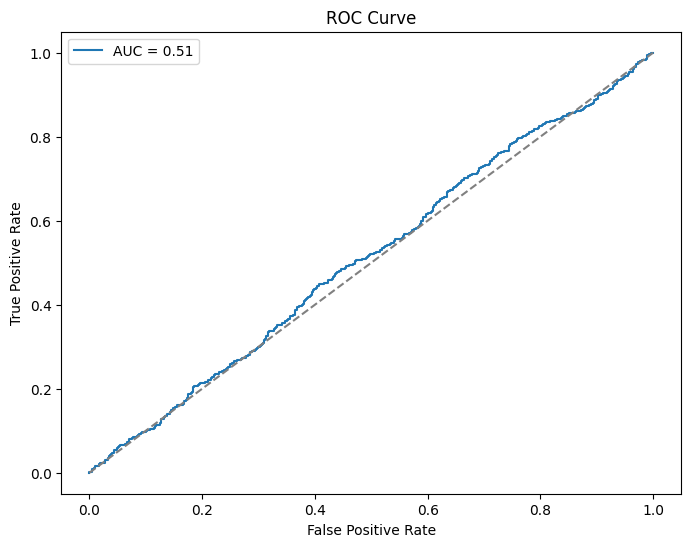

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Multiple models were evaluated including Logistic Regression, Decision Tree, KNN, and Random Forest.
- Random Forest with tuned hyperparameters gave the best F1-score and balanced performance.
- F1-score and ROC AUC were used to handle the slight class imbalance in the target variable.
- Therefore, the Random Forest model is selected for deployment.

In [29]:
import joblib

# Save the best model (Random Forest with best params)
joblib.dump(best_rf, 'model.pkl')


['model.pkl']